Some references

- flare detector: http://iopscience.iop.org/article/10.3847/1538-4357/aa789f
- power law detector: https://ece.ubc.ca/~zjanew/journal/ZJW_SP_APPPLDTranSing_27.pdf
- PSD of non-stationary signals: http://onlinelibrary.wiley.com/doi/10.1111/j.1365-2966.2011.18969.x/full
- Detection of transient events in train tracks: http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6457/pdf/imm6457.pdf
- Statistical signal processing: https://www.ece.rice.edu/~dhj/courses/elec531/notes.pdf
- KLMS bayesian Tobar: https://arxiv.org/pdf/1707.03450v1.pdf
- XRAY PAPER: https://arxiv.org/pdf/1702.04422.pdf

Correo de Jonathan:

Disculpa la demora, solamente que estamos en proceso de descargar las curvas de luz y de extraer los datos que nos sirvan. Te adjunto dos archivos eventos "_evt2.fits" (donde se encuentra la información del tiempo, la energía de los fotones que arribaron al detector, e información adicional de la observación), una curva de luz (source_lc.fits), y un archivo .py. Los archivos cut_evt2.fits y source_lc.fits pertenecen al primer transiente detectado (https://arxiv.org/abs/1702.04422), mientras que xt2_evt2.fits corresponde a otra detección pero aun no ha sido publicado. 

En el archivo evt2.fits extensión EVENTS  nos interesaría las columnas TIME y ENERGY. TIME está asociado con el tiempo de la detección y ENERGY con la energía del fotón incidente en eV. Podemos encontrar que para un mismo tiempo hay más de un fotón detectado, eso sería las "cuentas". Contando el número de fotones (cuentas) y el tiempo podemos construir una curva de luz.

Hay un archivo .py que generaría la curva de luz a partir del archivo evt2.fits 

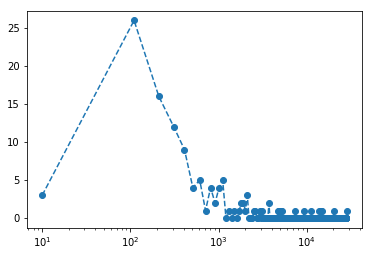

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from astropy.io import fits
import scipy.stats as st

from scipy.signal import argrelextrema
from scipy.optimize import least_squares, leastsq
from os import listdir
from os.path import join
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.decomposition import PCA

def get_light_curve(file_name, time_bin=100):
    with fits.open(file_name) as hdul:
        events = hdul[1].data
    time = np.sort(events['time'])
    #counts = events['counts']
    phased_time = (time - time[0])/time_bin
    x = np.arange(0, time[-1] - time[0], time_bin)
    y = np.bincount(np.trunc(phased_time).astype('int'))
    return time, x, y

time, x, y = get_light_curve('./cut_evt2.fits')
plt.plot(x+10,  y, linestyle='--', marker='o')
plt.gca().set_xscale('log')

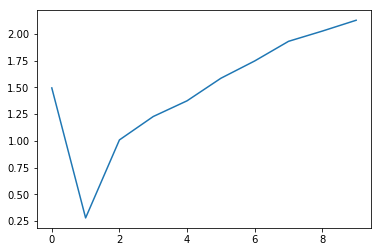

In [2]:
# define our (line) fitting function
#fitfunc = lambda p, x: p[0] + p[1]*(x)
def fitfunc(p, x, tmax):
    N = len(x)
    out = np.ones(shape=(N,))*p[0]
    #out[x>=1e+2] +=  p[1]*np.exp(-(x[x>=1e+2]-1e+2)/p[2]) + p[3]*np.exp(-(x[x>=1e+2]-1e+2)/p[4])
    out[x<tmax] = p[0] + p[1]*np.exp(-(tmax-x[x<tmax])/p[2]) 
    out[x>=tmax] = p[0] + p[1]*np.exp(-(x[x>=tmax]-tmax)/p[3]) 
    return out
errfunc = lambda p, x, y, tmax: (y - fitfunc(p, x, tmax))

pinit = [0.0, 1.0, 100.0, 100.0]
#logx = np.log10(x[(y>0) & (x>10)])
#logy = np.log10(y[(y>0) & (x>10)])
cost = np.zeros(shape=(10,))
for i in range(len(cost)):
    res = least_squares(errfunc, pinit, args=(x, y, x[i]))
    #model = np.ones(shape=(len(x)))*res.x[0]
    model = fitfunc(res.x, x, x[i])    
    cost[i] = np.average((y-model)**2)
plt.plot(cost)
#mu, sd, alpha = res.x
#print(res.x)

[1.22738057e-01 2.46871573e+01 4.65236585e+01 2.81268269e+02]


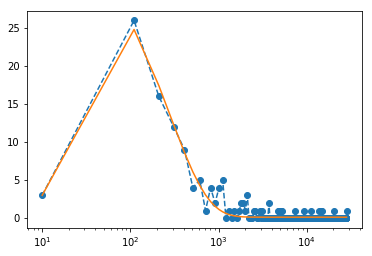

In [3]:
plt.plot(x+10,  y, linestyle='--', marker='o')
tmax = 1
res = least_squares(errfunc, pinit, args=(x, y, x[tmax]))
print(res.x)
#model = np.ones(shape=(len(x)))*res.x[0]
model = fitfunc(res.x, x, x[tmax])
plt.plot(x+10, model)
plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')

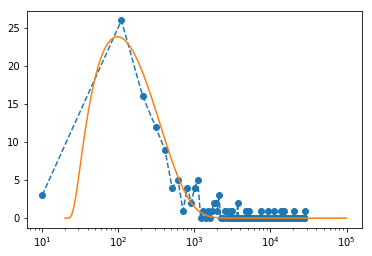

In [4]:
tau1 = 20.0
tau2 = 300.0
ts = 10
t = np.logspace(np.log10(ts), 5, num=100)
A = 40.0
model = A*np.exp(-tau1/(t-ts+1e-7) - (t-ts)/tau2)
plt.plot(x+10,  y, linestyle='--', marker='o')
plt.gca().set_xscale('log')
plt.plot(t+10, model)
#plt.xlim([0, 5000])

In [5]:
#%%time
time_bin = 100.0
window_size_aov = 100

def FRED_model(t, tau1, tau2, A, c):
    ts = -10.0
    return  c + A*np.sqrt(np.exp(2*tau1/tau2))*np.exp(-tau1/(t-ts) - (t-ts)/tau2)
    #return c + A

def power_law_model(t, A, k):
    N = len(t)
    out = np.zeros(shape=(N,))
    out[t < 200.0] = 0.0
    out[t >= 200.0] = A*np.log10(t[t>=200.0])**-k
    return out

def FRED_loss(x, *args):
    t, y = args
    tau1, tau2, A, c = x[0], x[1], x[2], x[3]
    return FRED_model(t[1:], tau1, tau2, A, c) - y[1:]

def power_law_loss(x, *args):
    t, y = args
    A, c, k = x[0], x[1], x[2]
    return power_law_model(t, A, c, k) - y

lc_path = "CSCVAR/"
file_list = [file for file in sorted(listdir(lc_path)) if file[-13:] == '_regevt3.fits']


def get_maxima_smooth(x, y, window_size=50, debug=False):
    simple_aov=np.zeros(shape=(5*len(y)//window_size))
    for m in range(len(simple_aov)):
        y_window = y[m*window_size//5:(m+1)*window_size//5+window_size]
        x_window = x[m*window_size//5:(m+1)*window_size//5+window_size]
        simple_aov[m] = np.median(y_window)
    local_max = argrelextrema(simple_aov, np.greater)[0]
    if debug:
        plt.plot(np.arange(0, len(simple_aov))*window_size, simple_aov)
        plt.plot(np.arange(0, len(simple_aov))*window_size, 
                 np.ones(shape=simple_aov.shape)*(np.median(y[y>0.0]) + 0.5*np.std(y[y>0.0])), 'r--')
    I = np.argsort(simple_aov[local_max])[::-1]
    local_max = local_max[I]
    filtered_local_max = local_max[simple_aov[local_max] > np.median(y[y>0.0]) + \
                                   np.std(y[y>0.0])]*window_size//5 + window_size//5
    filtered_local_max = filtered_local_max[filtered_local_max < len(x)]
    filtered_local_max = filtered_local_max[x[filtered_local_max] + 1e+4 < x[-1]] # have enough data
    return filtered_local_max

In [7]:
plt.scatter(param[:, 2], param[:, 3], c=nmse[:, 0]/var[:, 0], s=200, cmap=plt.cm.Reds_r)
for i in range(len(file_list)):
    if nmse[i, 0]/var[i, 0] < np.inf:
        plt.annotate(str(i), (param[i, 2], param[i, 3]))
plt.colorbar()
plt.xlabel('rise')
plt.ylabel('decay')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

NameError: name 'param' is not defined

acisfJ1617010m225925_001N020_r0045_regevt3.fits
[120]
[  32.39569282   43.39056237  308.19943079 6646.94487176]
0.3545316335177202


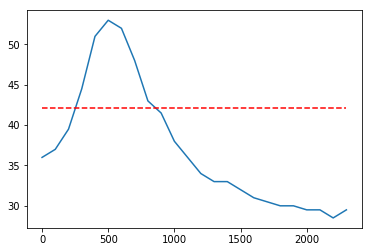

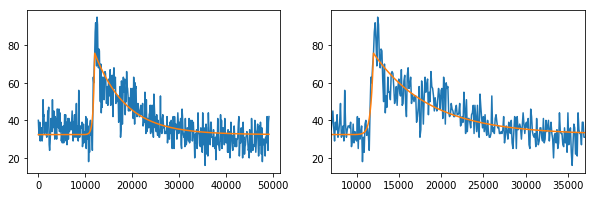

In [6]:
d = 28
print(file_list[d])
with fits.open(join(lc_path, file_list[d])) as hdul:
    events = hdul[1].data
    #print(hdul[1].data)
    time = np.sort(events['time'])
phased_time = (time - time[0])/time_bin
x = np.arange(0, time[-1] - time[0], time_bin)[:-1]
y = np.bincount(np.trunc(phased_time).astype('int'))[:-1]

plt.figure()

"""
f = np.linspace(0.0, 0.5/time_bin, num=10)
p = np.zeros(shape=(len(f), 10*len(y)//50))
y_center = y - np.mean(y)
for m in range(p.shape[1]):
    y_window = y_center[m*5:(m+1)*5+50]
    x_window = x[m*5:(m+1)*5+50]
    #y_window = y_window - np.mean(y_window)    
    for i in range(len(f)):
        p[i, m] = np.mean(y_window*np.cos(2.0*np.pi*f[i]*x_window)) + np.mean(y_window*np.sin(2.0*np.pi*f[i]*x_window))
plt.matshow(p)
max_window_idx = np.unravel_index(np.argmax(p), p.shape)[1]
plt.figure()
for i in range(6):
    plt.plot(p[i, :])
filtered_local_max = [5*max_window_idx+5]
"""
filtered_local_max = get_maxima_smooth(x, y, window_size=100, debug=True)
print(filtered_local_max)
fig = plt.figure(figsize=(10, 3))
ax_nozoom = fig.add_subplot(1, 2, 1)
ax_zoom = fig.add_subplot(1, 2, 2)
ax_nozoom.plot(x, y)
ax_zoom.plot(x, y)
for j, _max in enumerate(filtered_local_max):
    #popt, pcov  = curve_fit(power_law_model, x_window, y_window, p0=(np.std(y), 1.53), 
    #                            bounds=([0.0, 1.4], [np.inf, 1.6]))        
        
    #plt.plot(x[_max], y[_max], 'ro')
    #plt.plot(x_window+x[_max], power_law_model(x_window, *popt), linewidth=4, alpha=0.5)
    #plt.xlim([x[_max], x[_max+j_max]])
    #print(popt)
    j_max = np.argmin(np.absolute(x[_max:] - x[_max] - 2e+4))
    x_window = x[_max:_max+j_max] 
    y_window = y[_max:_max+j_max]
    #popt, pcov  = curve_fit(power_law_model, x_window, y_window, p0=(np.std(y), 1.53), 
    #                        bounds=([0.0, 1.0], [np.inf, 2.0]))

    res = least_squares(errfunc, pinit, args=(x, y, x[_max]))
    print(res.x)
    #model = np.ones(shape=(len(x)))*res.x[0]
    model = fitfunc(res.x, x, x[_max])    
    #nmse[i, j] = np.average((y_window-model)**2)
    
    #model = np.ones(shape=(len(x)))*res.x[0]
    #model[_max:] = fitfunc(res.x, x[_max:] - x[_max])
    ax_nozoom.plot(x, model)
    ax_zoom.plot(x, model)
    print(np.average((y-model)**2)/np.var(y))
    ax_zoom.set_xlim([x[_max-50], x[_max+j_max+50]])
    

In [8]:
T = 5e+4

In [9]:
%%time
# Comparing two point processes with kernels
# https://arxiv.org/pdf/1302.5964.pdf
# Eq. 5, nonlinear cross-intensity function
tau = 10.0
M = 20
D = np.zeros(shape=(M+1, M+1,))
K = np.zeros(shape=(M+1,))

for j in range(M+1):
    if j == M:
        t1, x1, y1 = get_light_curve('./cut_evt2.fits', time_bin=1)
    else:
        t1, x1, y1 = get_light_curve(join(lc_path, file_list[j]), time_bin=1)
    dt = x1[(x1<T) & (y1>np.mean(y1))][:, np.newaxis] - x1[(x1<T) & (y1>np.mean(y1))][:, np.newaxis].T
    #dt = (t1[t1<T] - t1[0])[:, np.newaxis] - (t1[t1<T] - t1[0])[:, np.newaxis].T
    K[j] = np.sum(np.exp(-np.absolute(dt)/tau))/dt.shape[0]**2
    
for j in range(M+1):    
    if j == M:
        t1, x1, y1 = get_light_curve('./cut_evt2.fits', time_bin=1)
    else:
        t1, x1, y1 = get_light_curve(join(lc_path, file_list[j]), time_bin=1)
    for i in range(j, M+1):
        if i == M:
            t2, x2, y2 = get_light_curve('./cut_evt2.fits', time_bin=1)
        else:
            t2, x2, y2 = get_light_curve(join(lc_path, file_list[i]), time_bin=1)
        
        #dt = (t1[t1<T+t1[0], np.newaxis] - t1[0]) - (t2[t2<T+t2[0], np.newaxis] - t2[0]).T
        #dt = x1[(x1<T) & (y1>0)][:, np.newaxis] - x2[(x2<T) & (y2>0)][:, np.newaxis].T
        dt = x1[(x1<T) & (y1>np.mean(y1))][:, np.newaxis] - x2[(x2<T) & (y2>np.mean(y2))][:, np.newaxis].T
        #D[i] = K1 + K2 - 2*np.sum(np.exp(-0.5*dt**2/s**2))/(dt.shape[0]*dt.shape[1])
        D[i, j] = K[i] + K[j] - 2*np.sum(np.exp(-np.absolute(dt)/tau))/(dt.shape[0]*dt.shape[1])
        D[j, i] = D[i, j]
#plt.plot(x+10,  y, linestyle='--', marker='o')
#plt.gca().set_xscale('log')

CPU times: user 5min 46s, sys: 1min 29s, total: 7min 16s
Wall time: 7min 17s


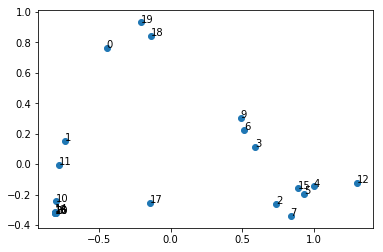

In [10]:
s = 0.01
G = np.exp(-0.5*D/s**2)
pca = PCA(n_components=2)
D_red = pca.fit_transform(G)
plt.scatter(D_red[:, 0], D_red[:, 1])
for i in range(M+1):
    plt.annotate(str(i), (D_red[i, 0], D_red[i, 1]))

In [18]:
%%time
# Paiva's thesis 4-4, generalized cross-correlation
lc_idx = 28
t1, x1, y1 = get_light_curve('./cut_evt2.fits', time_bin=1)
t2, x2, y2 = get_light_curve(join(lc_path, file_list[lc_idx]), time_bin=1)

D = list()
overlap = 20
N = np.argmin((t2[:] - t2[-1] + 5e+3)**2)//overlap
for i in range(np.amin([N, 1000])):
    idx = np.argmin( (t2[overlap*i:] - t2[overlap*i] - 5e+3)**2) + overlap*i
    if idx >= len(t2):
        break
    t2_tmp = t2[overlap*i:idx] - t2[overlap*i]
    dt = t1[:, np.newaxis] - t1[0] - t2_tmp[:, np.newaxis].T
    D.append(np.sum(np.exp(-np.absolute(dt)/tau))/(dt.shape[0]*dt.shape[1]))
D = np.array(D)

CPU times: user 5 s, sys: 6.8 ms, total: 5.01 s
Wall time: 5.04 s


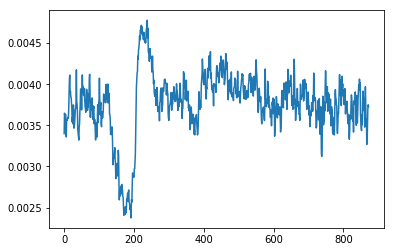

In [19]:
plt.plot(D)

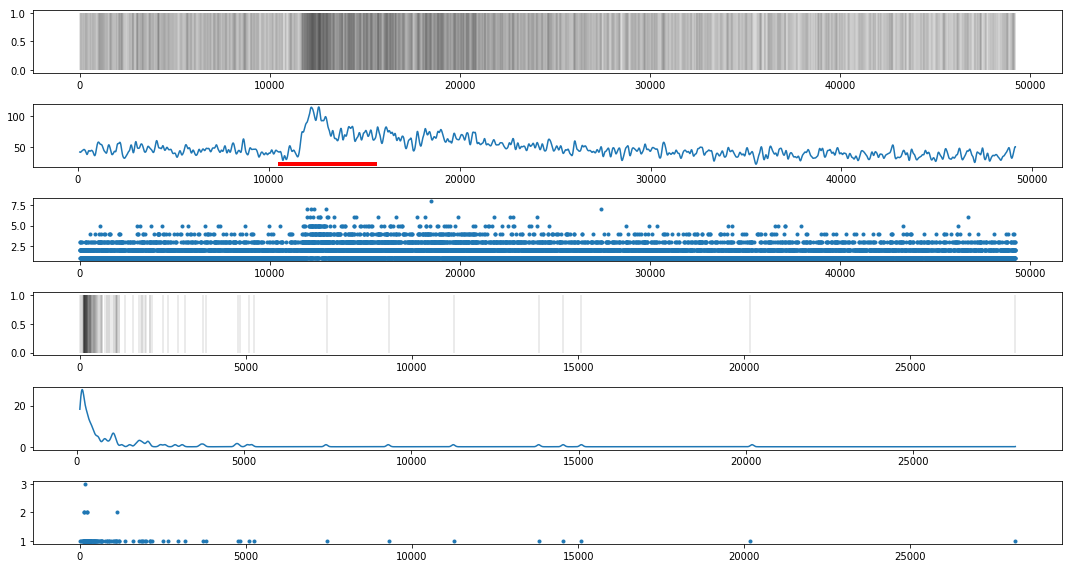

In [20]:
d = lc_idx
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(6, 1, 1)
t2, x2, y2 = get_light_curve(join(lc_path, file_list[d]), time_bin=1)
ax.vlines(t2[(t2<2*T+t2[0])] - t2[0], ymin=0.0, ymax=1.0, alpha=0.01)
ax = fig.add_subplot(6, 1, 2)
t_kde, x_kde = kde_spike(t2[t2<2*T+t2[0]], s=50)
ax.plot(t_kde,  x_kde, linestyle='-')
plt.plot([t2[np.argmin(D)*overlap] - t2[0], t2[np.argmin(D)*overlap] - t2[0] + 5e+3], 
         [np.amin(x_kde), np.amin(x_kde)], 'r', linewidth=4)
ax = fig.add_subplot(6, 1, 3)
ax.plot(x2[(x2<2*T) &(y2>np.mean(y2))], y2[(x2<2*T) &(y2>np.mean(y2))], '.')

ax = fig.add_subplot(6, 1, 4)
t, x, y = get_light_curve('./cut_evt2.fits', time_bin=1)
#t, x, y = get_light_curve(join(lc_path, file_list[d2]), time_bin=1)
ax.vlines(t[(t<T+t[0])] - t[0], ymin=0.0, ymax=1.0, alpha=0.1)
ax = fig.add_subplot(6, 1, 5)
t_kde, x_kde = kde_spike(t[t<T+t[0]], s=50)
ax.plot(t_kde,  x_kde, linestyle='-')
ax = fig.add_subplot(6, 1, 6)
ax.plot(x[(x<T) & (y>np.mean(y))], y[(x<T) & (y>np.mean(y))], '.')
#ax.set_xscale('log')
plt.tight_layout()

In [14]:
def kde_spike(t, s=1):
    #T = t[-1] - t[0]
    #new_t = np.arange(0.0, np.amin([T, t[-1] - t[0]]) , step=10.0)
    new_t = np.arange(2*s, t[-1] - t[0] - 2*s, step=10.0)
    smoothed = np.zeros(shape=(len(new_t),))
    for i in range(len(t)):
        smoothed += np.exp(-0.5*(new_t - t[i]+t[0])**2/s**2)
    return new_t, smoothed

In [263]:
#d = np.argmin(G[:-1, -1])
d = np.argmin(D)
d = 20
d2 = 10
print(d)
#d = 0
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(6, 1, 1)
t2, x2, y2 = get_light_curve(join(lc_path, file_list[d]), time_bin=1)
ax.vlines(t2[(t2<T+t2[0])] - t2[0], ymin=0.0, ymax=1.0, alpha=0.01)
ax = fig.add_subplot(6, 1, 2)
t_kde, x_kde = kde_spike(t2[t2<T+t2[0]], s=50)
ax.plot(t_kde,  x_kde, linestyle='-')
ax = fig.add_subplot(6, 1, 3)
ax.plot(x2[(x2<T) & (y2>np.mean(y2))], y2[(x2<T) & (y2>np.mean(y2))], '.')

ax = fig.add_subplot(6, 1, 4)
#t, x, y = get_light_curve('./cut_evt2.fits', time_bin=1)
t, x, y = get_light_curve(join(lc_path, file_list[d2]), time_bin=1)
ax.vlines(t[(t<T+t[0])] - t[0], ymin=0.0, ymax=1.0, alpha=0.01)
ax = fig.add_subplot(6, 1, 5)
t_kde, x_kde = kde_spike(t[t<T+t[0]], s=50)
ax.plot(t_kde,  x_kde, linestyle='-')
ax = fig.add_subplot(6, 1, 6)
ax.plot(x[(x<T) & (y>np.mean(y))], y[(x<T) & (y>np.mean(y))], '.')
#ax.set_xscale('log')
plt.tight_layout()

20


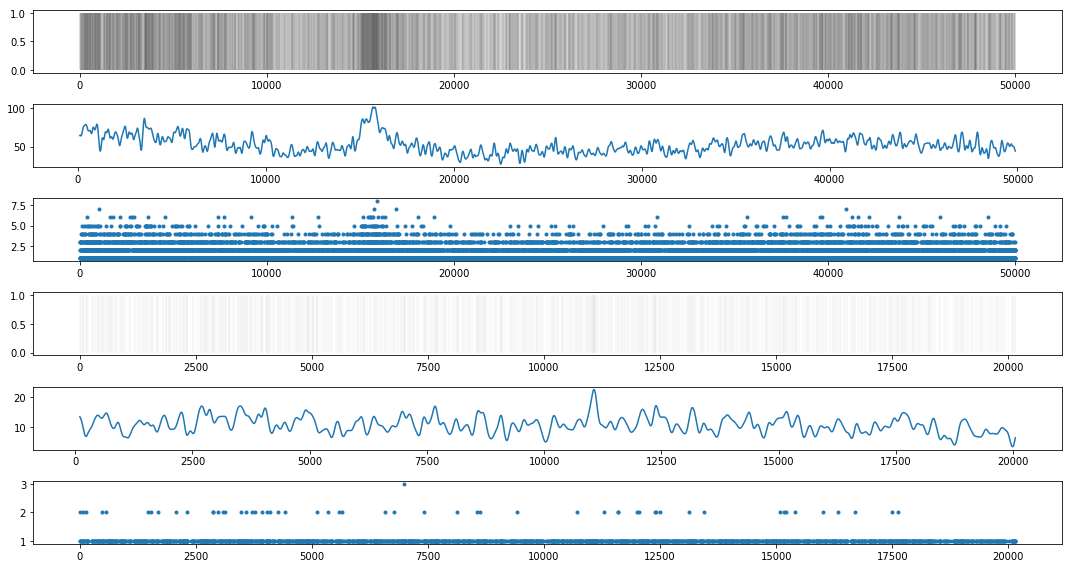

In [78]:
np.mean(y2)

1.1748377433849226

In [228]:
nmse = np.ones(shape=(len(file_list),1))*np.inf
var = np.zeros(shape=(len(file_list),1))
param = np.zeros(shape=(len(file_list), 4))
for i, file in enumerate(file_list):
    print("%d %s" %(i, file))
    with fits.open(join(lc_path, file)) as hdul:
        events = hdul[1].data
        #print(hdul[1].data)
        time = np.sort(events['time'])
    phased_time = (time - time[0])/time_bin
    x = np.arange(0, time[-1] - time[0], time_bin)[:-1]
    y = np.bincount(np.trunc(phased_time).astype('int'))[:-1]
    filtered_local_max = get_maxima_smooth(x, y, window_size=100)
    var[i] = np.var(y)
    # do not fit zeroes
    #x_fit = x[y>0]
    #y_fit = y[y>0]
    
    for j, _max in enumerate(filtered_local_max):
        if j == 1:
            break
        x_window = x[_max:_max+j_max] 
        y_window = y[_max:_max+j_max]
        res = least_squares(errfunc, pinit, args=(x, y, x[_max]))
        #model = np.ones(shape=(len(x)))*res.x[0]
        model = fitfunc(res.x, x, x[_max])    
        nmse[i, j] = np.average((y-model)**2)
        param[i, :] = res.x

0 acisfJ0234375m084659_001N020_r0003_regevt3.fits
1 acisfJ0239335p611653_001N020_r0001_regevt3.fits
2 acisfJ0240331p611332_001N020_r0028_regevt3.fits
3 acisfJ0255501p193011_001N020_r0003_regevt3.fits
4 acisfJ0331114p435406_001N020_r0118_regevt3.fits
5 acisfJ0331127p435301_001N020_r0241_regevt3.fits
6 acisfJ0344012p315758_001N020_r0242_regevt3.fits
7 acisfJ0344145p320536_001N020_r0012_regevt3.fits
8 acisfJ0344298p320840_001N020_r0018_regevt3.fits
9 acisfJ0421580p282620_001N020_r0003_regevt3.fits
10 acisfJ0455109p302158_001N020_r0007_regevt3.fits
11 acisfJ0538244p281634_001N020_r0007_regevt3.fits
12 acisfJ0541463m015511_001N020_r0334_regevt3.fits
13 acisfJ0546033m000834_001N020_r0008_regevt3.fits
14 acisfJ0546129m000544_001N020_r0001_regevt3.fits
15 acisfJ0546130m000957_001N020_r0056_regevt3.fits
16 acisfJ0546133m000623_001N020_r0003_regevt3.fits
17 acisfJ0546441p000344_001N020_r0006_regevt3.fits
18 acisfJ0554041p014018_001N020_r0003_regevt3.fits
19 acisfJ0837478p482901_001N020_r0002_reg